Tutorials of CPS using HBC dataset
===
**Interpretations of attention scores**
1. read the dataset
2. construct the graph (construct the multi-scale features, option)
2. train the model
3. generate the arbitrary resolution spots
4. visualize the results

In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.filterwarnings("ignore")

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import CPS

In [3]:
opt = CPS.config()
args = opt.parse_args(['--seed', '2025'])
args.prep_scale = False
args.sh_weights = True
args.dataset_path = '/mnt/d/Dataset/SRT_Dataset/4-Human_Breast_Cancer'
args.radius=300
args.clusters=20
args.self_loops=True
CPS.set_random_seed(args.seed)
args

Namespace(batch_size=256, clusters=20, coord_dim=2, dataset_path='/mnt/d/Dataset/SRT_Dataset/4-Human_Breast_Cancer', decoder='MLP', decoder_latent=[256, 512], distill=0.5, dropout=0.2, flow='source_to_target', freq=32, gpu=0, hvgs=3000, inr_latent=[256, 256, 256], k_list=[0, 1, 2, 3, 4, 5, 6, 7], latent_dim=64, lr=0.0001, max_epoch=500, max_neighbors=6, n_spot=0, num_heads=8, prep_scale=False, radius=300, seed=2025, self_loops=True, sh_weights=True, sigma=10.0, visual=True, weight_decay=0.0001)

Read the adata

In [4]:
adata = sc.read_visium(path=args.dataset_path, count_file='filtered_feature_bc_matrix.h5')
Ann_df = pd.read_csv(os.path.join(args.dataset_path, 'metadata.tsv'), sep='\t', header=0, index_col=0)
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'ground_truth']
adata

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Preprocess adata

In [5]:
adata.var_names_make_unique()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=args.hvgs)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=True, max_value=10)

adata_hvg = adata[:, adata.var['highly_variable']].copy()
adata.obsm['hvg_features'] = adata_hvg.X

Construct the spatial graph

In [6]:
spatial_edge = CPS.SpatialGraphBuilder(args)
pyg_data = spatial_edge.build_single_graph(adata, method='rknn')
print(pyg_data.num_nodes, pyg_data.num_genes, pyg_data.edge_index.shape)

3798 3000 torch.Size([2, 25862])


Train the CPS model

In [7]:
cps_model = CPS.CPSTrainer(args)
cps_model.fit(pyg_data)

  0%|          | 0/499 [00:00<?, ?it/s]

1.4336482286453247
1.4208760261535645
1.4093581438064575
1.399143934249878
1.3899178504943848
1.3816847801208496
1.374375581741333
1.367598295211792
1.361265778541565
1.3559067249298096
1.3506325483322144
1.346100926399231
1.3417458534240723
1.337913155555725
1.3342840671539307
1.3309680223464966
1.327974796295166
1.325088620185852
1.3224374055862427
1.3201488256454468
1.3178194761276245
1.3156026601791382
1.313576102256775
1.3117032051086426
1.3098808526992798
1.3083220720291138
1.3067383766174316
1.3052986860275269
1.3038448095321655
1.3025819063186646
1.301148772239685
1.2999318838119507
1.2989740371704102
1.2977449893951416
1.2967453002929688
1.2957545518875122
1.2948405742645264
1.2938742637634277
1.2929842472076416
1.292140245437622
1.2912348508834839
1.2905062437057495
1.2897614240646362
1.28903067111969
1.2882843017578125
1.287636160850525
1.2869789600372314
1.286332368850708
1.2856884002685547
1.284999132156372
1.2844038009643555
1.2837793827056885
1.283288598060608
1.28264725

Downstream analysis

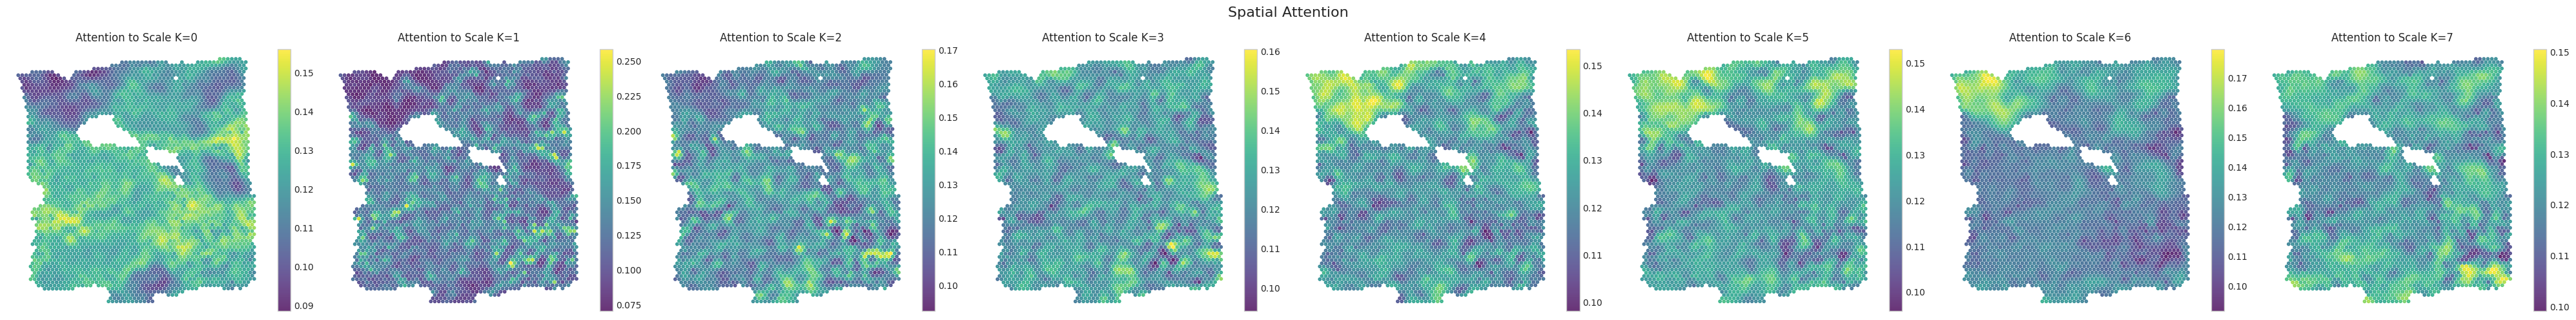

In [8]:
latent, attn = cps_model.infer_att_scores(pyg_data)
adata.obsm['z_t'] = latent
adata.obsm['attns'] = attn

In [9]:
adata.obsm['attns'].shape, adata.obsm['z_t'].shape

((3798, 8, 8), (3798, 64))

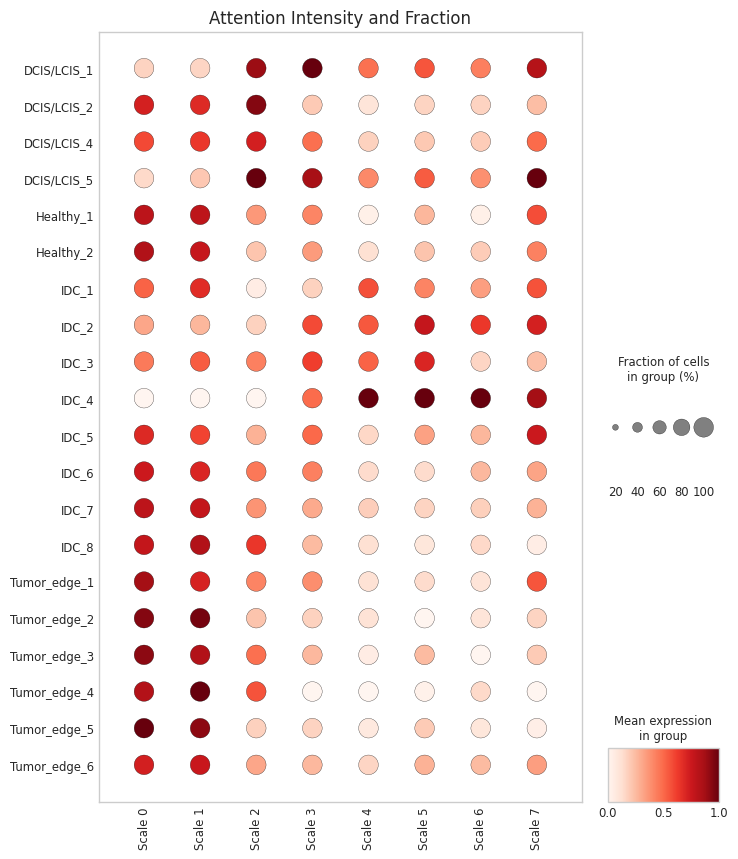

In [10]:
attn = np.mean(attn, axis=2)
adata.obsm['attn'] = attn
import scanpy as sc
import pandas as pd
import numpy as np

# 1. 提取数据
# 假设 adata.obsm['attn'] 的形状是 (n_cells, n_scales)
attn_data = adata.obsm['attn']
n_scales = attn_data.shape[1]

# 2. 构建临时的 AnnData 对象
# 我们将 attention score 当作 "基因" 放入 X 中
adata_attn = sc.AnnData(X=attn_data)

# 3. 转移元数据 (Obs)
# 必须把 Ground Truth 标签复制过来，用于分组
adata_attn.obs['Ground Truth'] = adata.obs['Ground Truth'].values

# 4. 命名变量 (Var)
# 给每一个尺度起个名字，这将成为横轴的标签
scale_names = [f'Scale {i}' for i in range(n_scales)]
adata_attn.var_names = scale_names

# 5. 绘制热点图 (Point plot)
# groupby: 纵轴的分组依据 (20个空间域)
# var_names: 横轴的变量 (不同尺度)
sc.pl.dotplot(
    adata_attn, 
    var_names=scale_names, 
    groupby='Ground Truth',
    standard_scale='var',  # 依然建议归一化，以便看清小尺度的变化
    cmap='Reds',
    figsize=(8, 10),
    title='Attention Intensity and Fraction'
)

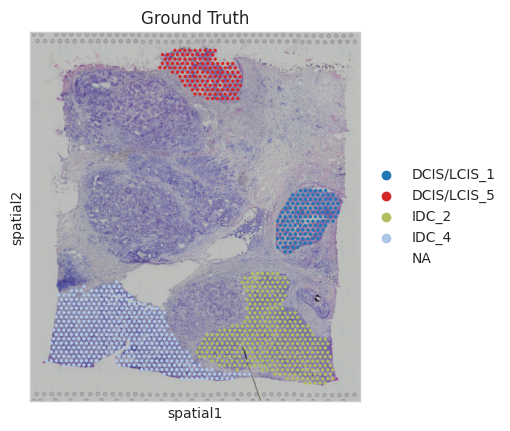

In [11]:
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"], groups=['DCIS/LCIS_1','DCIS/LCIS_5','IDC_4','IDC_2'])

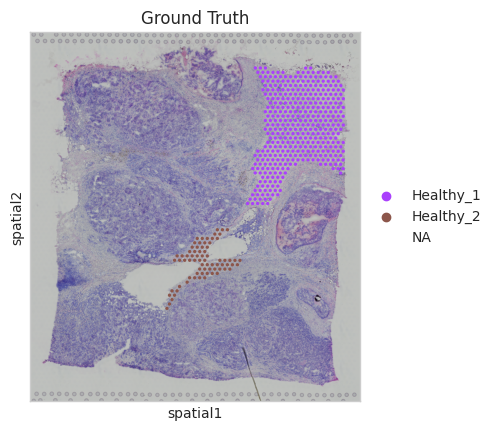

In [12]:
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"], groups=['Healthy_1','Healthy_2'])# 'Tumor_edge_5'

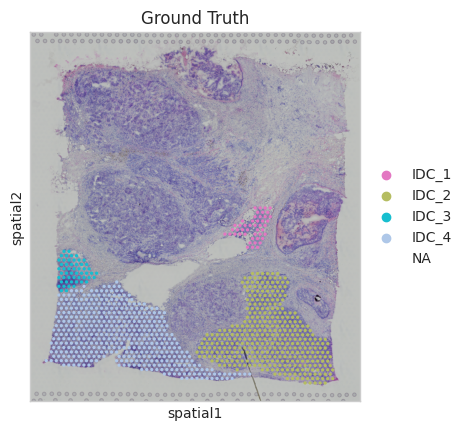

In [13]:
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"], groups=['IDC_1','IDC_2','IDC_4','IDC_3'])

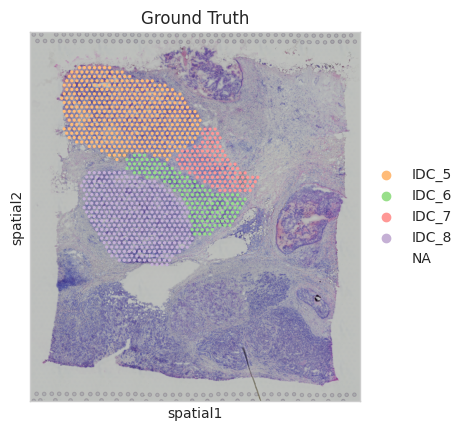

In [14]:
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"], groups=['IDC_5','IDC_6','IDC_7','IDC_8'])

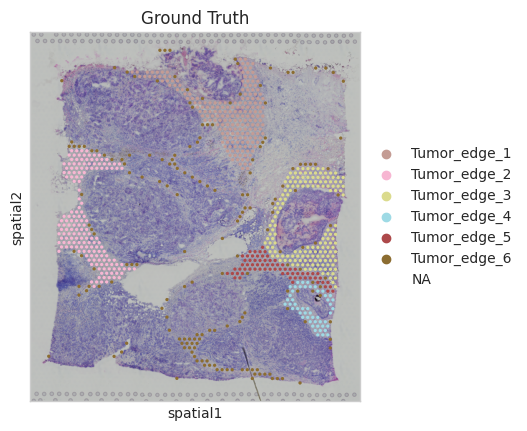

In [15]:
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"], groups=['Tumor_edge_1','Tumor_edge_2',
                                                                      'Tumor_edge_3','Tumor_edge_4',
                                                                      'Tumor_edge_5','Tumor_edge_6'])

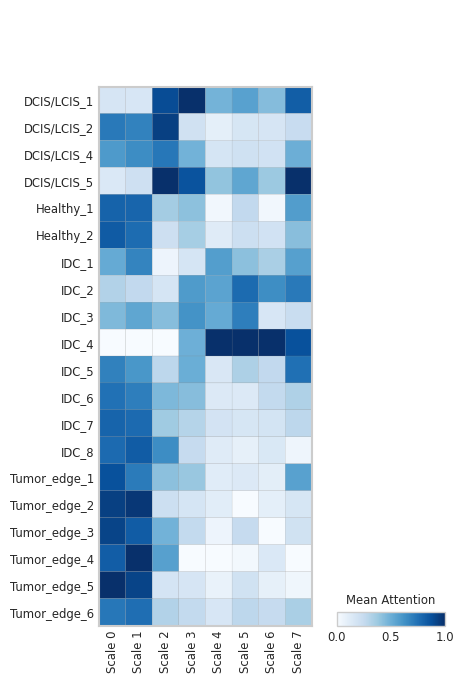

In [16]:
sc.pl.matrixplot(
    adata_attn, 
    var_names=scale_names, 
    groupby='Ground Truth', 
    colorbar_title='Mean Attention',
    cmap='Blues',
    standard_scale='var' # 可选：对每个尺度进行归一化 (0-1)，便于对比
)

In [17]:
attn

array([[0.14534384, 0.13149858, 0.12523046, ..., 0.11807238, 0.11923674,
        0.11559786],
       [0.10220326, 0.08375976, 0.12616533, ..., 0.14125086, 0.1526753 ,
        0.12741503],
       [0.13460344, 0.16284648, 0.12213099, ..., 0.11097604, 0.11107127,
        0.12927264],
       ...,
       [0.09635396, 0.07657035, 0.10613227, ..., 0.14256343, 0.16707888,
        0.13343346],
       [0.13450998, 0.17231011, 0.12154192, ..., 0.10602403, 0.11196666,
        0.11763144],
       [0.12343246, 0.15815823, 0.1343571 , ..., 0.11544313, 0.11464312,
        0.1192665 ]], dtype=float32)

In [26]:
# attn = np.clip(attn, 1e-10, 1.0)
attn = attn / attn.sum(axis=1, keepdims=True)
weights = np.arange(1, 9)  # 尺度权重
SES = attn @ weights
# SE = -np.sum(attn * np.log(attn), axis=1)
SE = -np.sum(attn * np.log(attn), axis=1)
adata.obs['SES'] = SES
adata.obs['SE'] = SE

[<Axes: title={'center': 'SES'}, xlabel='spatial1', ylabel='spatial2'>]

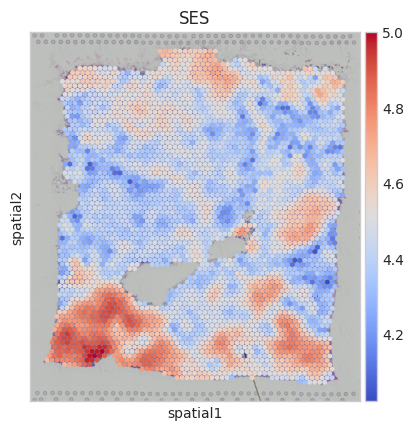

In [27]:
temp_adata = adata.copy()
temp_adata.obs['SES'] = SES
sc.pl.spatial(temp_adata, 
                color='SES',
                show=False, cmap='coolwarm',
                size=1.5)

[<Axes: title={'center': 'SE'}, xlabel='spatial1', ylabel='spatial2'>]

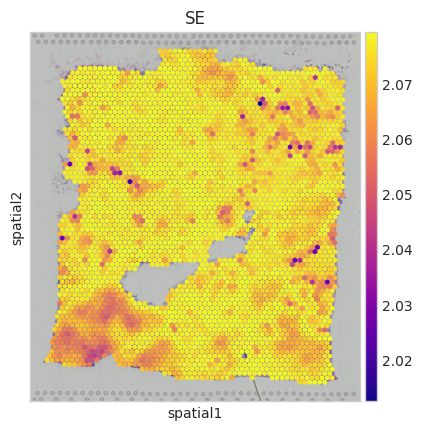

In [29]:
temp_adata = adata.copy()
temp_adata.obs['SE'] = SE
sc.pl.spatial(temp_adata, 
                color='SE',
                show=False, 
                cmap='plasma',
                size=1.5)

IDC1-4 vs IDC5-8

In [21]:

import scanpy as sc
import pandas as pd
import numpy as np

# 1. 创建一个新的子集，只包含 IDC 细胞
# 假设你的标签在 'Ground Truth' 列
idc_sub = adata[adata.obs['Ground Truth'].str.contains('IDC')].copy()

# 2. 定义分组逻辑
def define_idc_group(label):
    # 提取数字部分，例如 "IDC_1" -> 1
    try:
        num = int(label.split('_')[1])
        if 1 <= num <= 4:
            return 'IDC_1-4 (Small Scale)' # 假设这是之前看小尺度的一组
        elif 5 <= num <= 8:
            return 'IDC_5-8 (Large Scale)' # 假设这是之前看大尺度的一组
        else:
            return 'Other'
    except:
        return 'Other'

# 3. 应用分组
idc_sub.obs['IDC_Group'] = idc_sub.obs['Ground Truth'].apply(define_idc_group)

# 检查一下分组数量
print(idc_sub.obs['IDC_Group'].value_counts())

IDC_5-8 (Large Scale)    1103
IDC_1-4 (Small Scale)     924
Name: IDC_Group, dtype: int64


Up-regulated in IDC 5-8: 550 genes
Up-regulated in IDC 1-4: 2548 genes


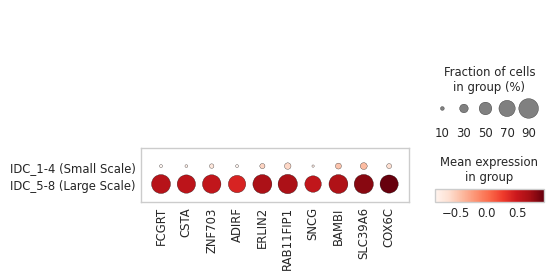

In [22]:
# 1. 确保使用归一化后的数据 (通常是 log1p 后的)
# sc.pp.normalize_total(idc_sub, target_sum=1e4)
# sc.pp.log1p(idc_sub)

# 2. 计算差异基因
# reference='IDC_1-4 (Small Scale)' 意味着：
# 正值 (positive scores) = 在 IDC 5-8 中高表达
# 负值 (negative scores) = 在 IDC 1-4 中高表达
sc.tl.rank_genes_groups(idc_sub, groupby='IDC_Group', method='wilcoxon', 
                        reference='IDC_1-4 (Small Scale)', groups=['IDC_5-8 (Large Scale)'])

# 3. 提取结果为 DataFrame
result = sc.get.rank_genes_groups_df(idc_sub, group='IDC_5-8 (Large Scale)')

# 过滤出显著的基因 (例如 pvals_adj < 0.05 & logfoldchanges > 1)
# 这一步是为了给后面的通路分析做准备
up_genes = result[(result.pvals_adj < 0.05) & (result.logfoldchanges > 0.5)]['names'].tolist()
down_genes = result[(result.pvals_adj < 0.05) & (result.logfoldchanges < -0.5)]['names'].tolist()

print(f"Up-regulated in IDC 5-8: {len(up_genes)} genes")
print(f"Up-regulated in IDC 1-4: {len(down_genes)} genes")

# 4. 可视化：火山图或 DotPlot
# 选出最显著的前 10 个基因画图看看
top_genes = result.head(10)['names'].tolist()
sc.pl.dotplot(idc_sub, top_genes, groupby='IDC_Group', dendrogram=True)

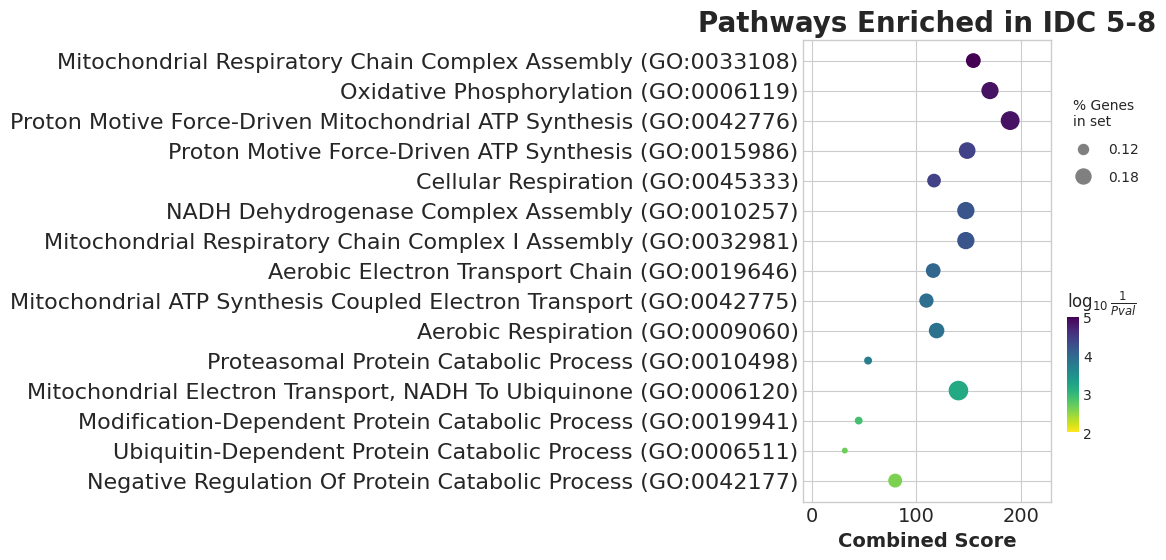

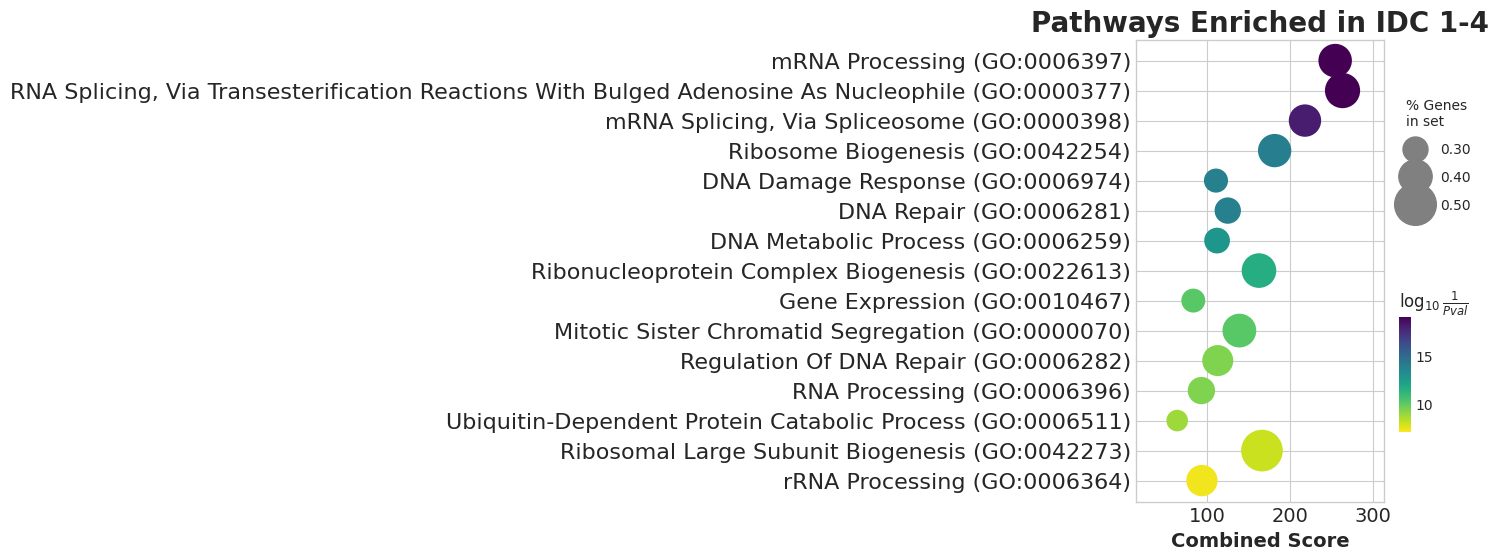

In [23]:
import gseapy as gp
import matplotlib.pyplot as plt

# 选择基因集库：
# 'KEGG_2021_Human', 'MSigDB_Hallmark_2020', 'GO_Biological_Process_2023'
gene_sets = ['MSigDB_Hallmark_2020', 'GO_Biological_Process_2023']

# 1. 分析 IDC 5-8 高表达的通路 (Up-regulated)
enr_up = gp.enrichr(gene_list=up_genes,
                 gene_sets=gene_sets,
                 organism='human', # or 'mouse'
                 outdir=None)

# 2. 分析 IDC 1-4 高表达的通路 (Down-regulated / Base)
enr_down = gp.enrichr(gene_list=down_genes,
                 gene_sets=gene_sets,
                 organism='human',
                 outdir=None)

# 3. 绘图 (Dotplot)
# 展示 IDC 5-8 的前15个显著通路
from gseapy import dotplot
ax = dotplot(enr_up.res2d, title='Pathways Enriched in IDC 5-8', cmap='viridis_r', size=10, top_term=15)
plt.show()

# 展示 IDC 1-4 的前15个显著通路
ax = dotplot(enr_down.res2d, title='Pathways Enriched in IDC 1-4', cmap='viridis_r', size=10, top_term=15)
plt.show()

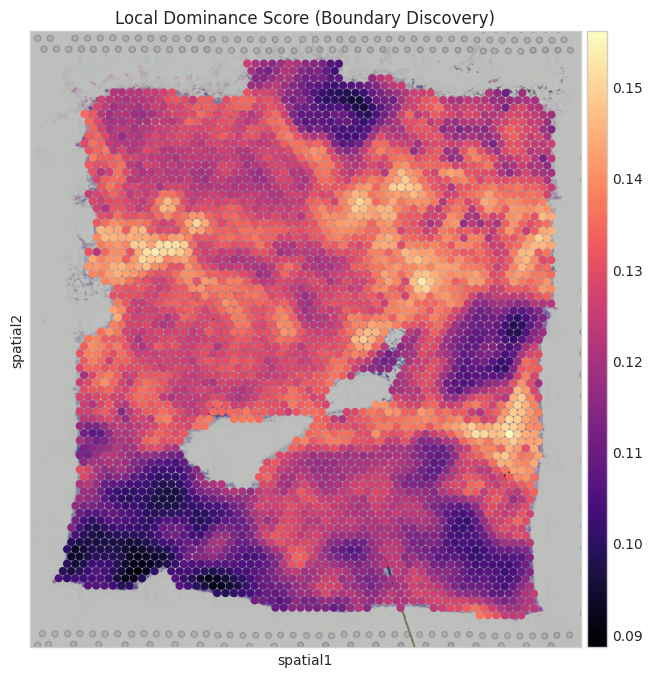

In [24]:
# ==========================================
# 新增功能：计算并可视化局部主导度 (Local Dominance)
# ==========================================

# 1. 定义什么是“局部”尺度
# 这里我们要累加前 k_local_threshold + 1 个尺度的权重
# 如果 k_local_threshold = 1，则累加 k=0 (Self) 和 k=1 (1-hop)
k_local_threshold = 1

# 2. 计算局部主导度得分
# attn 已经是归一化过的 (sum=1)，所以直接累加局部列即可
# attn[:, :2] 取的是第0列和第1列
local_attn_score = np.sum(attn[:, :k_local_threshold], axis=1)

# 3. 将得分保存到 adata.obs 中以便绘图
adata.obs['Local_Dominance'] = local_attn_score

# 4. 可视化
# 使用 'magma' 色谱 (黑色-紫色-亮黄)，亮黄色代表高局部主导度(即潜在的边界)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
sc.pl.spatial(adata, 
              img_key="hires", 
              color='Local_Dominance', 
              cmap='magma', 
              size=1.5, 
              title='Local Dominance Score (Boundary Discovery)',
              ax=ax,
              show=False)

# 可选：保存图片
# plt.savefig('Local_Dominance_Boundary.png', dpi=300, bbox_inches='tight')
plt.show()

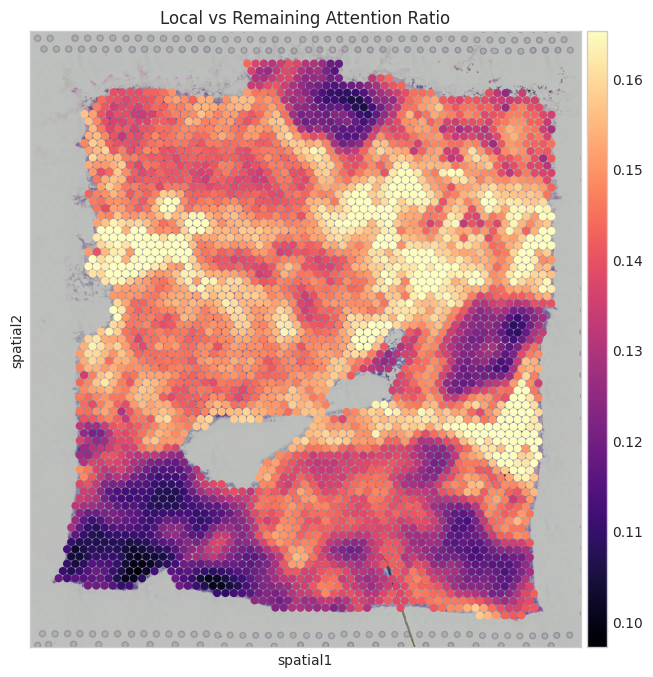

In [25]:
# ==========================================
# 进阶版：计算“局部 vs 剩余”注意力比率 (Local-to-Remaining Ratio)
# ==========================================
import numpy as np

# 1. 定义局部阈值 (k=0 和 k=1 为局部)
k_local_threshold = 1

# 2. 分别计算“局部”和“剩余”的权重和
# 局部 (Local): k <= 1
local_sum = np.sum(attn[:, :k_local_threshold], axis=1)

# 剩余 (Remaining/Global): k > 1
remaining_sum = np.sum(attn[:, k_local_threshold:], axis=1)

# 3. 计算比率 (Ratio)
# 加上一个极小值 1e-6 防止除以零 (如果 remaining_sum 为 0)
# 这个指标的物理含义：局部注意力是长程注意力的多少倍？
# 在边界处，这个值可能会非常大（例如 局部0.9 / 剩余0.1 = 9倍）
ratio_score = local_sum / (remaining_sum + 1e-6)

# (可选) 如果比率极值太大，可以取个 log 压缩一下范围，方便画图
# ratio_score = np.log1p(ratio_score) 

# 4. 保存并画图
adata.obs['Local_Global_Ratio'] = ratio_score

fig, ax = plt.subplots(figsize=(8, 8))
sc.pl.spatial(adata, 
              img_key="hires", 
              color='Local_Global_Ratio', 
              cmap='magma',  # 依然推荐 magma 或 inferno，高值亮黄
              size=1.5,
              # 设定 vmax 可以防止个别极端值掩盖整体趋势，
              # np.percentile(ratio_score, 95) 表示只看前 95% 的数值分布
              vmax=np.percentile(ratio_score, 95), 
              title='Local vs Remaining Attention Ratio',
              ax=ax,
              show=False)

plt.show()